In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [3]:
isocronas = pd.read_csv('../../Isocronas/Regression_Iso.txt', header = 0)

In [4]:
from scipy.interpolate import interp1d

Text(0.5, 1.0, 'Interpolação linear: cor do turnoff \n em função da idade')

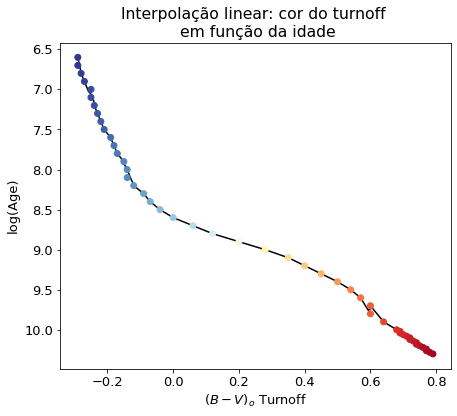

In [5]:
f1 = interp1d(isocronas['(B-V)TurnOff'],  isocronas['Age'],kind= 'linear')
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 


font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

fig,ax = plt.subplots(figsize=(7,6)) #(figsize=(10,8))
plt.gca().invert_yaxis()



interpol_colour = np.linspace(isocronas['(B-V)TurnOff'].min(),isocronas['(B-V)TurnOff'].max(),100)
plt.plot(interpol_colour,f1(interpol_colour), color = 'k')
plt.scatter(isocronas['(B-V)TurnOff'], isocronas['Age'], c = isocronas['(B-V)TurnOff'],cmap = 'RdYlBu_r', zorder = 10)
plt.ylabel('log(Age)')
plt.xlabel(r'$(B-V)_o$' + ' Turnoff')
plt.title('Interpolação linear: cor do turnoff \n em função da idade')


In [6]:
#plt.scatter( isocronas['Age'], isocronas['(B-V)TurnOff'],   cmap = 'RdYlBu_r')

### Aglomerado 3, E(B-V)=0.3

In [7]:
ag3 = pd.read_csv('../P1/LinearRegressAG3.txt', header = 0)
E = 0.3
ag3.head()

,Slope,Intercept,Slope_Error,Intercept_Error,TurnOffColor
0,6.172207,5.731096,0.009577,0.01184,0.479499


In [8]:
idade3 = f1(ag3['TurnOffColor ']-E)
idade3

array([8.87437334])

In [21]:
idade3=8.9

In [22]:
isocro3 = isocronas[isocronas['Age'] ==idade3]
isocro3

,Age,Slope,Intercept,Slope_Error,Intercept_Error,R_Value,(B-V)TurnOff,MvTurnOff,Ajustadas/Total
26,8.9,5.849284,0.847525,0.04543,0.031448,0.999759,0.2,1.57,0.4166666666666667= 10/24


In [23]:
## Método do Slope do Aglomerado
def distancia(a,b,b0,E):
    return 10**((a*E + (b-b0) - E*3.1 + 5 )/5)
d3 = distancia(ag3['Slope'].item(), ag3[' Intercept'].item(), isocro3['Intercept'].item(),E)
d3

144.89274596847855

In [12]:
i3 = pd.read_csv('../P1/ag3.txt',header = 0)
i3.head()

,B-V,V
0,1.204533,12.559566
1,0.700453,8.983786
2,1.582116,15.913256
3,1.540805,15.910005
4,1.023942,11.734744


In [24]:
len(i3)

2842

In [25]:
iso = pd.read_csv('../../Isocronas/isocro.csv', header = 0)

idades = iso['log(Age)']
age = np.array([])
for element in idades:
    if element in age:
        continue
    elif element not in age:
        age = np.append(age,element)

iso3 = iso[iso['log(Age)']==idade3]

Text(0, 0.5, '$V$')

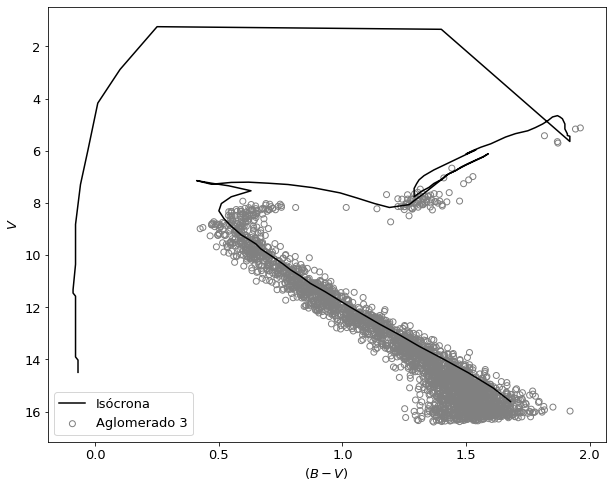

In [26]:
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 


font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

fig,ax = plt.subplots(figsize=(10,8)) #(figsize=(10,8))
plt.gca().invert_yaxis()
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] +5*np.log10(d3/10)+3.1*E , label = 'Isócrona', color = 'black', zorder = 10)
plt.scatter(i3['B-V'] ,i3['V'], label = 'Aglomerado 3', color = 'none', edgecolor = 'grey')
plt.legend(frameon=True)
plt.xlabel(r"$(B-V)$")
plt.ylabel(r"$V$")

In [28]:
modulodist = 5*np.log10(d3/10) + E*3.1
Xiso = iso3['(B-V)o'] + E
Yiso = iso3['Mv'] + modulodist 
Xaglo = i3['B-V'] 
Yaglo = i3['V']

dist_pontos = np.zeros_like(Xaglo)
distancias = []
for i in range(len(Xaglo)):
    pontos_aglo = np.array([Xaglo[i],Yaglo[i]])
    for x,y in zip(Xiso,Yiso):
        xy = np.array([x,y])
        distancias.append(math.dist(xy,pontos_aglo))
    dist_pontos[i] = min(distancias)

dist_pontos.mean(), modulodist

(0.003061595285796876, 6.735233215667751)

In [29]:
n_interacoes = 30
incremento = 0.05
medias = np.zeros((2,n_interacoes))
dist_loop = modulodist
import time
start = time.time()
for j in range(0,n_interacoes,1):
    Xiso = iso3['(B-V)o'] + E
    Yiso = iso3['Mv'] + dist_loop 
    Xaglo = i3['B-V'] 
    Yaglo = i3['V']
    dist_loop = dist_loop + incremento
    dist_pontos = np.zeros_like(Xaglo)
    distancias = []
    for i in range(len(Xaglo)):
        pontos_aglo = np.array([Xaglo[i],Yaglo[i]])
        for x,y in zip(Xiso,Yiso):
            xy = np.array([x,y])
            distancias.append(math.dist(xy,pontos_aglo))
        dist_pontos[i] = min(distancias)
    medias[0][j] = dist_pontos.mean()
    medias[1][j] = np.std(dist_pontos)
end = time.time()

print('Tempo decorrido: ', end-start)

Tempo decorrido:  250.17512369155884


In [30]:
local = np.where(medias[0]==min(medias[0]))
local

(array([2]),)

Text(0, 0.5, '$V$')

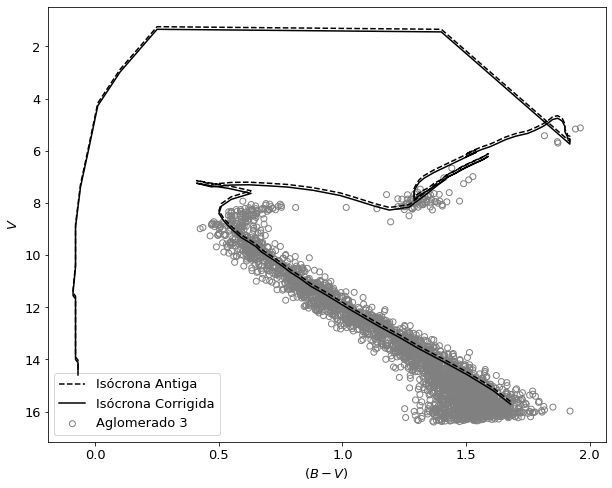

In [33]:
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 


font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

fig,ax = plt.subplots(figsize=(10,8)) #(figsize=(10,8))
plt.gca().invert_yaxis()
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] + modulodist ,  '--', label = 'Isócrona Antiga', color = 'black', zorder = 10)
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] + modulodist + 0.05*local[0], label = 'Isócrona Corrigida', color = 'black', zorder = 10)
plt.scatter(i3['B-V'] ,i3['V'], label = 'Aglomerado 3', color = 'none', edgecolor = 'grey')
plt.legend(frameon=True)
plt.xlabel(r"$(B-V)$")
plt.ylabel(r"$V$")
#plt.title('Ajuste da Isócrona de log(Age ) = 7.0 \n Método Slope Aglomerado')

In [32]:
real = 7 #- 0.5*3.1
real, modulodist, modulodist + local[0]*0.05

(7, 6.735233215667751, array([6.83523322]))

In [23]:
np.where(medias[0]==medias[0].min()),np.where(medias[1]==medias[1].min())

((array([7]),), (array([0]),))

In [1]:
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 


font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

fig,ax = plt.subplots(figsize=(10,8)) #(figsize=(10,8))
plt.gca().invert_yaxis()
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] + modulodist , '--', label = 'Isócrona Antiga', color = 'black', zorder = 10)
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] + modulodist + 0.05*local[0], label = '7', color = 'red', zorder = 10)
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] + modulodist + 0.05, label = '0', color = 'brown', zorder = 10)
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] + modulodist + 0.05*4, label = '4', color = 'yellow', zorder = 10)
plt.plot(iso3['(B-V)o'] + E,iso3['Mv'] + 7, label = 'Real', color = 'blue', zorder = 10)
plt.scatter(i3['B-V'] ,i3['V'], label = 'Aglomerado 2', color = 'none', edgecolor = 'grey')
plt.legend(frameon=True)
plt.xlabel(r"$(B-V)$")
plt.ylabel(r"$V$");

NameError: name 'plt' is not defined

In [ ]:
#Interpolacao entre dois pontos da isocrona, Chi^2...